# WRF perturbation key results

In this work we compare WRF control output to output in which temperature or moisture have been perturbed around given vertical levels. The aim is to explore linear response functions as described in [Kuang 2010](https://doi.org/10.1175/2009JAS3260.1).

In [ ]:
import sys
sys.path.append('git/wrf_lrf_les/analysis/')

import modules.wrf_perturbation as wp
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import numpy as np
import datetime
import xarray

print("Report last updated at " + str(datetime.datetime.utcnow()) + ' UTC.')

In [ ]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(threads_per_worker=1)
client = Client(cluster)  
print(client)

## Settings

In [ ]:
# Perturbation details.
perts = {'res': ['1 km', '1 km Chimene', '4 km', 'LES'], # Dataset names.
         'dir': ['1km', '1km_Chimene', '4km', 'LES'],    # Dataset directories.
         'levels': ['850', '412'],                       # Perturbed levels in hPa.
         'T': ['0.5', '-0.5'],                           # Temperature perturbations in K day-1.
         'q': ['0.0002', '-0.0002']}                     # Specific humidity perturbations in kg kg-1 day-1.

# Input directories with dataset names as keys.
basedir = '/g/data/up6/tr2908/em_quarter_ss/v4.1.4/original_1km/output/'
inputs = wp.input_map(perts=perts, basedir=basedir)
    
# Figure settings.
plt.rcParams['figure.figsize'] = wp.FIGURE_SIZE  # Figure size for non-facetted plots.
plt.rcParams['font.size'] = 12                   # Font size for plots.
plt.rcParams['axes.formatter.useoffset'] = False # Don't use offsets in plots.

# The point at which the RCE run ends and control + perturbation runs begin.
runs_start = {'1 km': '2000-03-01', '1 km Chimene': '2000-03-01', '4 km': '2000-03-01', 'LES':  '2000-04-26'} 

# Start and end times for designated RCE periods.
start_time = {'1 km': '2000-04-01', '1 km Chimene': '2000-04-01', '4 km': '2000-04-01', 'LES':  '2000-05-20'}
end_time =   {'1 km': '2000-06-01', '1 km Chimene': '2000-06-01', '4 km': '2000-06-01', 'LES':  '2000-05-27 10:00'}
               
# Pressure levels to plot individually [hPa].
plot_levels = [850, 500, 410, 100] 

## Data input

In [ ]:
%%time
wrfvars = wp.read_wrfvars(inputs=inputs, quiet=True)

In [ ]:
wrfvars = wp.add_mass_flux(wrfvars)

## Setup notes

- Fixed SST (301.15 K).
- Ideal radiative cooling profile as per [Herman and Kuang (2013)](https://doi.org/10.1002/jame.20037).
- Ideal evaporation as per [Chua et al., 2019](http://dx.doi.org/10.1029/2019GL082408).
- Potential temperature and water vapour mixing ratio $q$ are relaxed in the stratosphere (above 160 hPa) to reference RCE profiles, as suggested by [Herman and Kuang (2013)](https://doi.org/10.1002/jame.20037). The reference profile is the profile from the RCEMIP project for the 1 km and 4 km runs, and a the mean 1 km RCE profile over 7 days at the end of the 2000-03 for the LES runs.

In [ ]:
# Figure settings.
wp.model_setups(inputs=inputs)

Here are perturbation settings used in each run:

In [ ]:
wp.perturbation_details(inputs)

In [ ]:
plt.rcParams['figure.figsize'] = (5,8)
wp.compare_perturbation_forcing(dat=wrfvars['1 km'].sel(Dataset='Control'), p_pert=850, k_pert=10)
plt.rcParams['figure.figsize'] = wp.FIGURE_SIZE

## Radiative-convective equilibrium (RCE)

To determine when the simulations have reached RCE, we look for stabilisation of the precipitable water (PW) field. Here is spatially-averaged PW by time for each simulation. The green highlighted region is the time span over which average profiles are calculated for all runs.

In [ ]:
for res in wrfvars.keys():
    wrfvars[res].pw.plot(hue='Dataset', figsize=(13,6))
    plt.axvspan(xmin=start_time[res], xmax=end_time[res], alpha=0.3, color='green')
    plt.title(res)
    plt.tight_layout()
    plt.show()

Remove the 'RCE' dataset, since the reference dataset from here on is 'Control'.

In [ ]:
for res in wrfvars.keys():
    wrfvars[res] = wrfvars[res].drop_sel(Dataset='RCE').sel(time=slice(runs_start[res], None))
    del(inputs[res]['RCE'])

## Comparison of mean profiles

In [ ]:
%%time
profs_LES = wrfvars['LES'].sel(time=slice(start_time['LES'], end_time['LES'])).mean('time').load()
profs_1km = wrfvars['1 km'].sel(time=slice(start_time['1 km'], end_time['1 km'])).mean('time').load()
profs_1km_Chimene = wrfvars['1 km Chimene'].sel(time=slice(start_time['1 km'], end_time['1 km'])).mean('time').load()
profs_4km = wrfvars['4 km'].sel(time=slice(start_time['4 km'], end_time['4 km'])).mean('time').load()

In [ ]:
variables = ['T', 'rh', 'qrain', 'qcloud', 'qice', 'qsnow', 'qgraup', 'Dataset']

p_LES = profs_LES[variables].assign_coords({'Resolution': 'LES'})
p_1km = profs_1km[variables].assign_coords({'Resolution': '1 km'})
p_1km_Chimene = profs_1km_Chimene[variables].assign_coords({'Resolution': '1 km Chimene'})
p_4km = profs_4km[variables].assign_coords({'Resolution': '4 km'})

profs = xarray.concat([p_LES, p_1km, p_1km_Chimene, p_4km], dim='Resolution')
profs['T'] = profs.T + 300
profs = profs.sel(level=slice(1000, 200))

profs = profs.to_dataframe().reset_index()
qdat = profs[np.logical_or(profs.Dataset == 'Control', np.array([x[0] for x in profs.Dataset]) == 'q')]
Tdat = profs[np.logical_or(profs.Dataset == 'Control', np.array([x[0] for x in profs.Dataset]) == 'T')]
mean_dat = profs[profs.Dataset == 'Control']

In [ ]:
def plot_mean_profs(variables, varnames):
    _, axs = plt.subplots(ncols=len(variables), nrows=2, figsize=(14,12))
    for i, v in enumerate(variables):
        sb.lineplot(data=qdat, x=v, y='level', hue='Dataset', style='Resolution', ax=axs[0,i], legend=(i==len(variables)-1), sort=False, estimator=None)
        sb.lineplot(data=Tdat, x=v, y='level', hue='Dataset', style='Resolution', ax=axs[1,i], legend=(i==len(variables)-1), sort=False, estimator=None)

        for ax in axs[:,i].flat:
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.invert_yaxis()

        axs[1,i].set_xlabel(varnames[i])
        axs[0,i].set_title(f'{v} with perturbed q')
        axs[1,i].set_title(f'{v} with perturbed T')

    axs[0,0].set_ylabel('Interpolated pressure [hPa]')
    axs[1,0].set_ylabel('Interpolated pressure [hPa]')

    plt.tight_layout()
    plt.show()
    
plot_mean_profs(variables=['rh', 'qrain', 'qcloud'],
                varnames=['Relative humidity [%]', 'Rain MR [kg kg-1]', 'Cloud water MR [kg kg-1]'])

plot_mean_profs(variables=['qice', 'qsnow', 'qgraup'],
                varnames=['Ice MR [kg kg-1]', 'Snow MR [kg kg-1]', 'Graupel MR [kg kg-1]'])

In [ ]:
_, axs = plt.subplots(ncols=len(variables), figsize=(20,4))

for i, v in enumerate(variables):
    sb.lineplot(data=mean_dat, x=v, y='level', hue='Resolution', ax=axs[i], legend=(i==len(variables)-1), sort=False, estimator=None)
    axs[i].set_ylabel('Interpolated pressure [hPa]')
    axs[i].set_xlabel(varnames[i])
    axs[i].invert_yaxis()
    
plt.tight_layout()
plt.show()

## Mean profiles over RCE period

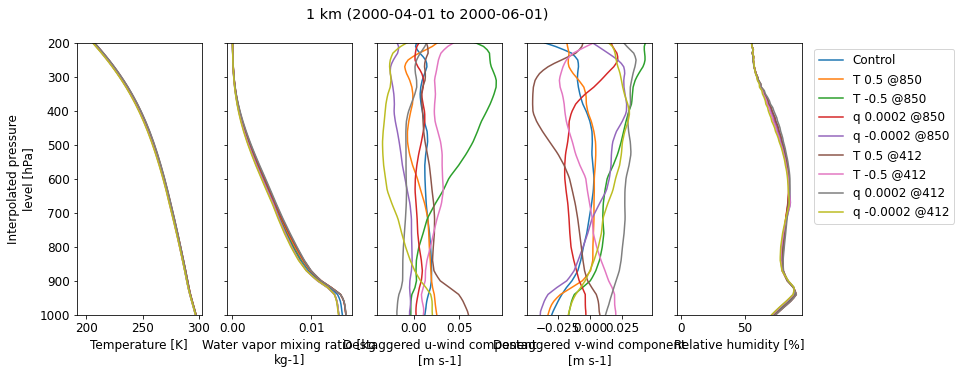

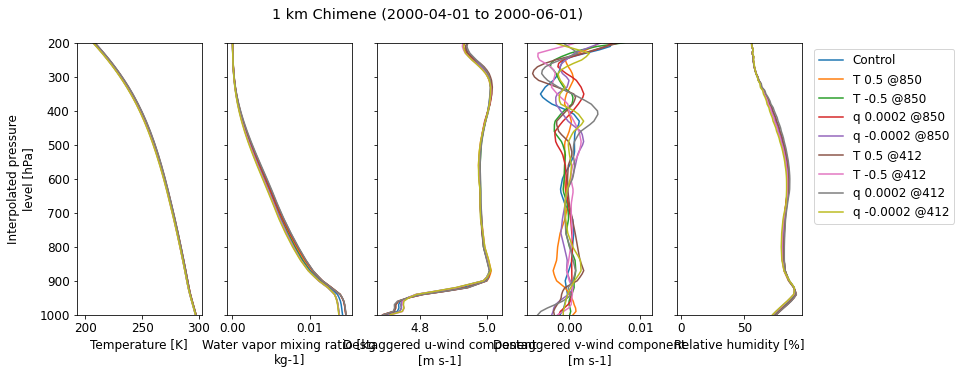

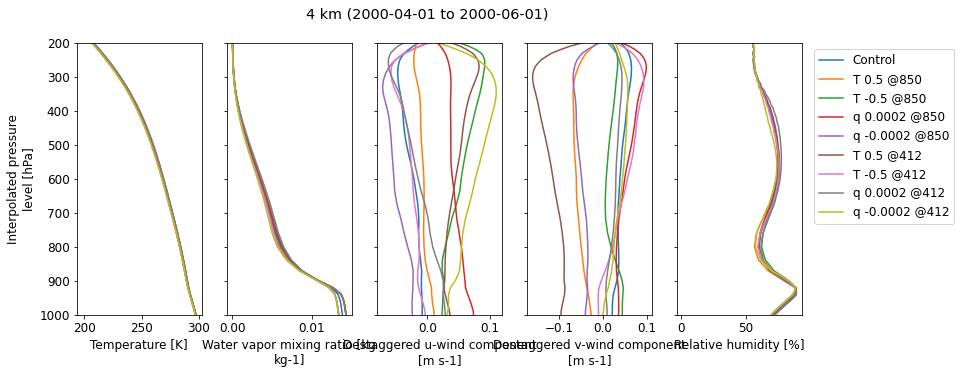

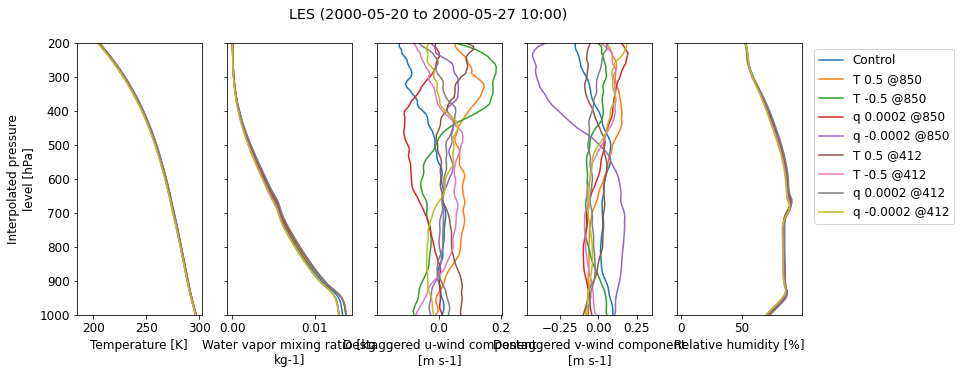

In [250]:
profs = {}
for res in wrfvars.keys():
    profs[res] = wp.mean_profiles(dat=wrfvars[res], start=start_time[res], end=end_time[res], figsize=(13,5), 
                                  title=res + ' (' + str(start_time[res]) + ' to ' + str(end_time[res]) + ')')

## Perturbation differences in averaged RCE profiles

Differences here are defined as `perturbed - control`. The red vertical line shows zero difference.

In [251]:
# Convert q from kg kg-1 to g kg-1.
for res in profs.keys():
    for v in ['q', 'qrain', 'qcloud', 'qice', 'qsnow', 'qgraup']:
        with xarray.set_options(keep_attrs=True):
            profs[res][v] = profs[res][v] * 1000
        profs[res][v].attrs['units'] = 'g kg -1'

In [ ]:
# Read in reference (Kuang 2010) results.
ref_dir = '/g/data/up6/tr2908/LRF_SCM_results/'
refs = {'q_dq': {'var': 'q', 'pert': 'q', 
                 'file': 'SAM/matrix_M_inv/M_inv_sam_q_dqdt_norm_kuang.csv'},
        'q_dT': {'var': 'q', 'pert': 'T', 
                 'file': 'SAM/matrix_M_inv/M_inv_sam_q_dtdt_norm_kuang.csv'},
        'T_dq': {'var': 'tk', 'pert': 'q', 
                 'file': 'SAM/matrix_M_inv/M_inv_sam_t_dqdt_norm_kuang.csv'},
        'T_qT': {'var': 'tk', 'pert': 'T', 
                 'file': 'SAM/matrix_M_inv/M_inv_sam_t_dtdt_norm_kuang.csv'}}

ref_pressures = pd.read_csv(ref_dir+'/pressures', header=None).round(0).astype(int).to_dict()[0]
pert_levels = [412, 850]

res = pd.DataFrame()

for ref, key in refs.items():
    dat = pd.read_csv(ref_dir + key['file'], header=None)
    
    # Column is perturbation level, row is reponse level.
    dat = dat.rename(columns=ref_pressures, index=ref_pressures)
    dat = dat.loc[:,pert_levels]
    
    dat['var'] = key['var']
    dat['perturbed'] = key['pert']
    dat = dat.reset_index()#set_index('var')
    dat = dat.rename(columns={'index': 'level'})
    
    res = pd.concat([res, dat])

res = res.melt(id_vars=['level', 'perturbed', 'var'])
res = res.pivot(index=['level', 'variable', 'perturbed'], columns=['var'])
res.columns = ['q', 'tk']
res = res.reset_index()
res['Dataset'] = 'K10 ' + res.perturbed + ' @' + res.variable.astype(str)
ref = res.drop(columns=['variable']).set_index(['level', 'Dataset'])#.reset_index()
ref = xarray.Dataset.from_dataframe(ref)

In [ ]:
diff_set = []

for res in wrfvars.keys():
    for v in ['T', 'q']:
        ds = ['Control'] + [x for x in profs[res].Dataset.values if x[0] == v]
        diffs = wp.diff_means(profs=profs[res][['tk','q']], control_name='Control')
        neg = [x for x in ds if '-' in x]
        pos_diffs = diffs.drop_sel(Dataset=neg)
        #pos_diffs = pos_diffs.assign_coords({'perturbed': v}).expand_dims('perturbed')
        pos_diffs = pos_diffs.assign_coords({'resolution': res}).expand_dims('resolution')
        diff_set.append(pos_diffs)

diff_set = xarray.merge(diff_set)

# for v in ['T', 'q']:
#     for res in ['LES', '1 km']:
        
#         sub = profs[res].sel(Dataset=ds)
#         _, axs = wp.compare_profiles(profs=sub, figsize=[12,5], variables=['tk','q'],
#                                      neg=[x for x in ds if '-' in x],
#                                      title=(res + ', perturbed ' + v + 
#                                             ' (RCE: ' + str(start_time[res]) + 
#                                             ' to ' + str(end_time[res]) + ')'), 
#                                      loc='best',
#                                      xlims={'tk': [-0.3, 1], 
#                                             'q': [-0.25, 0.5]})
        
#         sb.lineplot(data=ref[ref.perturbed==v], x='tk', y='level', style='Dataset', 
#                     ax=axs[0], sort=False, color='black', legend=True)
#         sb.lineplot(data=ref[ref.perturbed==v], x='q', y='level', style='Dataset', 
#                     ax=axs[1], sort=False, color='black', legend=False)
          
#         axs[0].legend(bbox_to_anchor=(2.81, 0.62))
#         plt.show()

In [ ]:
col_850 = ['T 0.5 @850', 'q 0.0002 @850']
col_412 = ['T 0.5 @412', 'q 0.0002 @412']

In [ ]:
from matplotlib.lines import Line2D
cmap = sb.color_palette()
custom_lines = [Line2D([0], [0], color=cmap.as_hex()[0], lw=2),
                Line2D([0], [0], color=cmap.as_hex()[1], lw=2),
                Line2D([0], [0], color=cmap.as_hex()[2], lw=2),
                Line2D([0], [0], color='black', lw=2, linestyle='--')]

In [ ]:
def plot_comparison(ref, diff_set, ref_412, ref_850, ds_412, ds_850, title):
    _, axs = plt.subplots(ncols=2, nrows=2, figsize=(10,10))
    axs[0,0].plot(ref.sel(Dataset=ref_412).tk, ref.level, color='black', linestyle='--')
    axs[0,1].plot(ref.sel(Dataset=ref_412).q, ref.level, color='black', linestyle='--')
    axs[1,0].plot(ref.sel(Dataset=ref_850).tk, ref.level, color='black', linestyle='--')
    axs[1,1].plot(ref.sel(Dataset=ref_850).q, ref.level, color='black', linestyle='--')

    diff_set.sel(Dataset=ds_412, drop=True).tk.plot(ax=axs[0,0], hue='resolution', y='level', add_legend=False)
    diff_set.sel(Dataset=ds_412, drop=True).q.plot(ax=axs[0,1], hue='resolution', y='level', add_legend=False)
    diff_set.sel(Dataset=ds_850, drop=True).tk.plot(ax=axs[1,0], hue='resolution', y='level', add_legend=False)
    diff_set.sel(Dataset=ds_850, drop=True).q.plot(ax=axs[1,1], hue='resolution', y='level', add_legend=False)

    for ax in axs[:,0]:
        ax.set_xlim(-0.1, 1.2)
        
    for ax in axs[:,1]:
        ax.set_xlim(-0.25, 0.5)
    
    for ax in axs.flat:
        ax.invert_yaxis()
        ax.set_ylabel('')
        ax.set_ylim(1000, 200)

    for ax in axs[0,:]:
        ax.set_xlabel('')
        ax.set_title('412 hPa')
    
    for ax in axs[1,:]:
        ax.set_title('850 hPa')
        
    axs[0,0].set_ylabel('Level [hPa]')
    axs[1,0].set_ylabel('Level [hPa]')

    axs[0,1].legend(custom_lines, diff_set.resolution.values.tolist() + ['K10'])
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    
plot_comparison(ref, diff_set, ref_412='K10 T @412', ref_850='K10 T @850', 
                ds_412='T 0.5 @412', ds_850='T 0.5 @850', title='T forcing')

In [ ]:
plot_comparison(ref, diff_set, ref_412='K10 q @412', ref_850='K10 q @850', 
                ds_412='q 0.0002 @412', ds_850='q 0.0002 @850', title='q forcing')

In [ ]:
ds = ['Control'] + [x for x in profs[res].Dataset.values if x[0] == v]
sub = profs[res].sel(Dataset=ds)
neg = []

diffs = wp.diff_means(profs=sub, control_name='Control')
pos_diffs = diffs.drop_sel(Dataset=neg)
neg_diffs = -1 * diffs.sel(Dataset=neg)
diffs = xarray.concat([pos_diffs, neg_diffs], dim='Dataset')

In [ ]:
for v in ['T', 'q']:
    for res in wrfvars.keys():
        ds = ['Control'] + [x for x in profs[res].Dataset.values if x[0] == v]
        sub = profs[res].sel(Dataset=ds)
        wp.compare_profiles(profs=sub, figsize=[13.5,5], neg=[x for x in ds if '-' in x],
                            title=(res + ', perturbed ' + v + ' (RCE: ' + str(start_time[res]) + 
                                   ' to ' + str(end_time[res]) + ')'),
                            xlims={'tk': [-0.1,1.2],
                                   'q': [-0.25, 0.5],
                                   'rh': [-4, 7]})

In [ ]:
for v in ['T', 'q']:
    for res in wrfvars.keys():
        ds = ['Control'] + [x for x in profs[res].Dataset.values if x[0] == v]
        sub = profs[res].sel(Dataset=ds)
        wp.compare_profiles(profs=sub, figsize=[13.5,5], neg=[x for x in ds if '-' in x],
                            variables=['conv_mass_flux', 'wa'],
                            title=(res + ', perturbed ' + v + ' (RCE: ' + str(start_time[res]) + 
                                   ' to ' + str(end_time[res]) + ')'),
                            xlims={'conv_mass_flux': [-0.011, 0.005],
                                   'wa': [-0.0002, 0.0003]},
                            loc='upper right')

In [ ]:
for v in ['T', 'q']:
    for res in wrfvars.keys():
        ds = ['Control'] + [x for x in profs[res].Dataset.values if x[0] == v]
        sub = profs[res].sel(Dataset=ds)
        wp.compare_profiles(profs=sub, figsize=[13.5,5], neg=[x for x in ds if '-' in x],
                            variables=['rh', 'qrain', 'qcloud'],
                            title=(res + ', perturbed ' + v + ' (RCE: ' + str(start_time[res]) + 
                                   ' to ' + str(end_time[res]) + ')'),
                            #xlims={'rh': [-0.011, 0.005],
                            #       'qcloud': [-0.0002, 0.0003]},
                            loc='upper right')

## Convective organisation

In [ ]:
dat = wrfvars['1 km Chimene'].sel(time=slice('2000-05-01', None)).sel(Dataset=['Control', 'T 0.5 @850', 'q 0.0002 @850', 'T 0.5 @412', 'q 0.0002 @412'])
dat.pw_scaled_var.plot(x='time', hue='Dataset')

In [265]:
dat = profs['LES']
control_name = 'Control'

diffs = wp.diff_means(profs=dat, control_name=control_name)

variables = ['tk', 'q', 'qcloud', 'qrain', 'qice', 'qsnow', 'qgraup']
pos_perts = ['T 0.5 @850', 'T 0.5 @412', 'q 0.0002 @850', 'q 0.0002 @412']
neg_perts = ['T -0.5 @850', 'T -0.5 @412', 'q -0.0002 @850', 'q -0.0002 @412']


In [266]:
%%time
diffs = diffs.load()

CPU times: user 46.6 s, sys: 1.01 s, total: 47.6 s
Wall time: 49.3 s


In [267]:
perts = ['T @850', 'T @412', 'q @850', 'q @412']

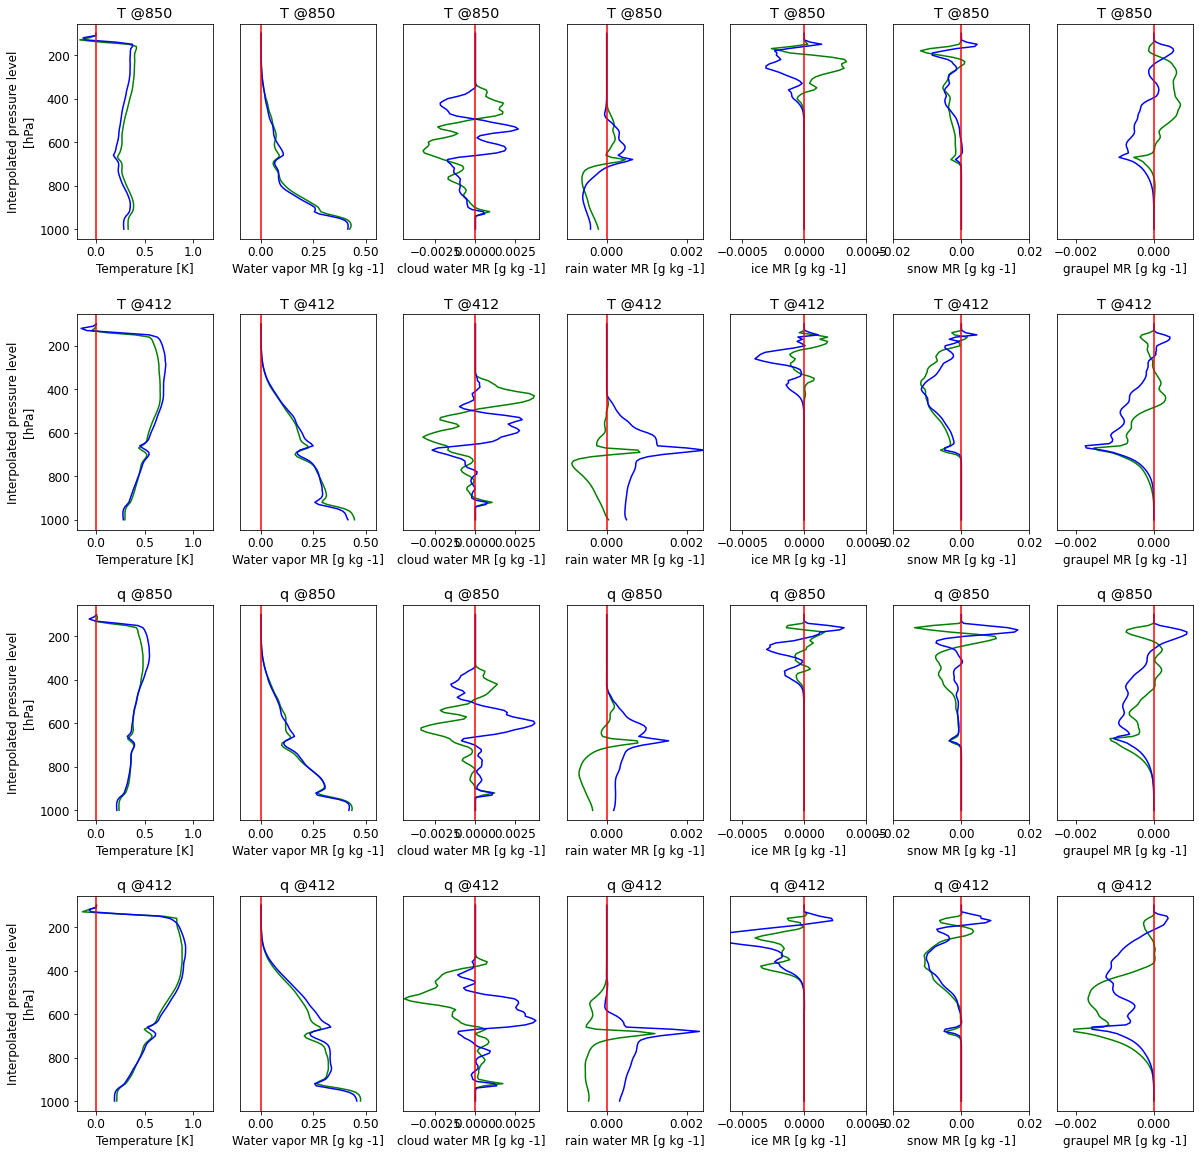

In [280]:
lims = {'tk': [-0.2, 1.2],
        'q': [-0.1, 0.55],
        #'qcloud': np.array([-0.2, 0.2])*1e-2,
        #'qrain': np.array([-0.2, 0.2])*1e-2,
        #'qice': np.array([-0.2, 0.2])*1e-2,
        #'qsnow': np.array([-0.2, 0.2])*1e-2,
        #'qgraup': np.array([-0.2, 0.2])*1e-2}
        'qcloud': np.array([-4.5, 4])*1e-3,
         'qrain': np.array([-1, 2.4])*1e-3,
         'qice': np.array([-0.6, 0.5])*1e-3,
         'qsnow': np.array([-20, 20])*1e-3,
         'qgraup': np.array([-2.5, 1])*1e-3}

# Perts in rows, variables in columns.
fig, axs = plt.subplots(nrows=len(pos_perts), ncols=len(variables), figsize=(20,20),
                        gridspec_kw={'hspace':0.35})

for i in np.arange(len(pos_perts)):
    for j, v in enumerate(variables):
        (diffs.sel(Dataset=neg_perts[i])[v]*-1).plot(y='level', color='green', ax=axs[i,j])
        diffs.sel(Dataset=pos_perts[i])[v].plot(y='level', color='blue', ax=axs[i,j])
        
        att=diffs.sel(Dataset=pos_perts[i])[v].attrs
        lab = f'{att["long_name"].replace("mixing ratio", "MR")} [{att["units"]}]'
        axs[i,j].set_xlabel(lab)
        axs[i,j].axvline(0, color='red')
        axs[i,j].set_title(perts[i])
        axs[i,j].invert_yaxis()
        axs[i,j].ticklabel_format(useOffset=False, style='plain') 
        axs[i,j].set_xlim(lims[v][0], lims[v][1])
        if j > 0:
            axs[i,j].set_ylabel('')
            axs[i,j].set_yticks([])

## Extra notes

### WRF versions

- RCE runs were all made using a version of WRF in which:
     - Wind damping on $U$ and $V$ was to zero over the whole vertical column with a damping timescale of 4 days.
     - The wind tendencies `RURELAXTEN` and `RVRELAXTEN` were not properly added to the `halo` and `period` definitions, so incorrect values may have been used in the code that adds a staggered tendency field to an unstaggered tendency field (`add_a2c_u` and `add_a2c_v`). 
 
- All other runs (control and perturbations) were made using an updated version in which
     - Wind damping is applied with a three hour time scale above 100 hPa, decreasing to no damping below 160 hPa, except in wind shear case when wind shear is enforced by relaxing winds to shear profiles over the whole vertical column, with a three hour time scale.
     
- For LES RCE run, the initial profile and RCE profile to which stratospheric q is nudged are based on the 1 km RCE run from `2000-03-25` to `2000-03-31` (7 days at the end of the RCE run).